# This model is developed based on the three month recent data from 202008 to 202010

In [1]:
# Import packages
import pandas as pd

import numpy as np
import _pickle as cpickle

import sys
sys.path.insert(0, '/home/ec2-user/SageMaker/mymodule/')
from common_functions import psi
from common_functions import ks
from common_functions import data_vars
from impute_functions import setMax

import matplotlib.pyplot as plt

%matplotlib inline
import boto3

In [2]:
#old s3_source_path='s3://mf-ml-ds/propensity_to_pay/Monthly_Validation/val_202009/'
# YYYYMM = '202012'
bucket_name = 'mf-ml-ds'
# s3_source = 's3://'+ bucket_name +'/propensity_to_fund/model_monitor/val_'
# s3_source_path  = s3_source + YYYYMM
# s3_score_target  = 'propensity_to_fund/model_monitor/val_' + YYYYMM +'/'
# # pps_score_file_name = 'xgb_weighted_score_pot_' + YYYYMM +'.csv'

# psi_file_path = 's3://'+ bucket_name + '/' + s3_score_target
model_path = 'propensity_to_pay/final_model/'

s3 = boto3.resource('s3')

In [3]:
def upload_model(model, model_name):
    with open(model_name, 'wb') as f:
        cpickle.dump(model, f)
    s3.meta.client.upload_file(model_name, bucket_name, model_path + model_name)

In [4]:
def download_model(model_name):
    #model_name = 'slowsecure_xgb_model_w'
    s3.meta.client.download_file(bucket_name, model_path + model_name, model_name)
    with open(model_name, 'rb') as f:
        xgb = cpickle.load(f)
        return xgb

In [13]:
    xgb = download_model('pot90_xgb_model_v2_2')

In [14]:
pot90_columns=xgb.get_booster().feature_names

In [21]:
#read in the csv model development data
#read in the csv model development data
df1=pd.read_csv('s3://mf-ml-ds/propensity_to_pay/Monthly_Validation/val_202008/pot90.csv')
df2=pd.read_csv('s3://mf-ml-ds/propensity_to_pay/Monthly_Validation/val_202009/pot90.csv')
df3=pd.read_csv('s3://mf-ml-ds/propensity_to_pay/Monthly_Validation/val_202010/pot90.csv')
df=pd.concat([df1,df2, df3],ignore_index=True)

In [16]:
# df_columns = pd.read_csv('s3://mf-ml-ds/propensity_to_pay/output/pps_attributes.csv')
combine=[*pot90_columns, *['badflag']]

In [17]:
df=df[combine]


In [18]:
df.shape

(53889, 38)

In [19]:
df['badflag'].value_counts()

1    45585
0     8304
Name: badflag, dtype: int64

In [20]:
df.columns[pd.Series(df.columns).str.startswith('ADA')]
df.columns

Index(['MOBVintageThread', 'yrs_on_job_dbl', 'number_of_payments',
       'NumberOfCars', 'MaxCarYear', 'Times29_6mo', 'Times30_6mo',
       'Times90_6mo', 'Times29_Ever', 'Times30_Ever', 'Times60_Ever',
       'ADA_3239', 'ADA_3439', 'ADA_3837', 'ADA_3939', 'ADA_3727', 'ADA_3471',
       'ADA_3476', 'ADA_3535', 'ADA_3759', 'ADA_3802', 'ADA_3804', 'ADA_3865',
       'ADA_3872', 'ADA_3164', 'ADA_3273', 'ADA_3323', 'ADA_3410', 'ADA_3540',
       'ADA_3761', 'ADA_3827', 'ADA_3012', 'ADA_3013', 'ADA_3914', 'ADA_3963',
       'upb_ratio', 'state_risk', 'badflag'],
      dtype='object')

In [14]:
import scorecardpy as sc
#filter variable via missing rate, iv, identcal value rate
# dt_s=sc.var_filter(df, y='fund_flag', iv_limit=0.01,missing_limit = 0.95, identical_limit = 0.95)

bins=sc.woebin(df, y="badflag", save_breaks_list='breaks_list')

[INFO] creating woe binning ...
Binning on 53889 rows and 38 columns in 00:00:14
[INFO] The breaks_list is saved as breaks_list_20210211_233306.py


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/scorecardpy/woebin.py:1203: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax1 = plt.subplots()
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/scorecardpy/woebin.py:1203: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax1 = plt.subplots()
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/scorecardpy/woebin.py:1203: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figu

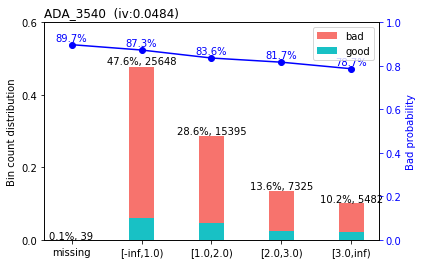

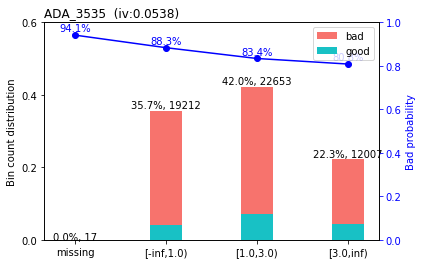

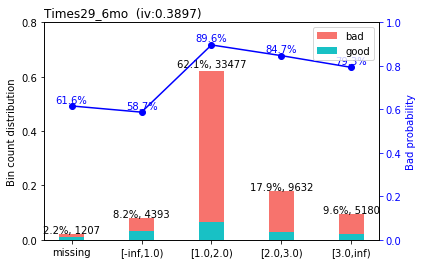

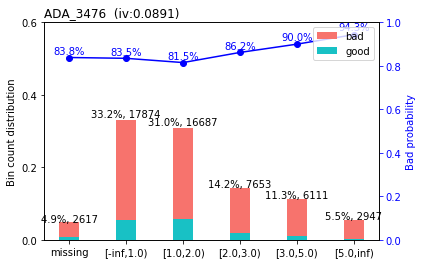

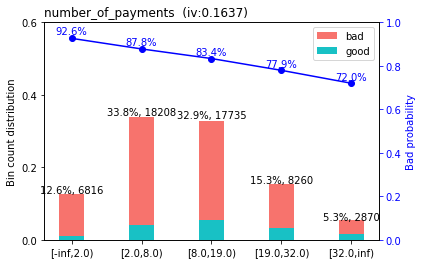

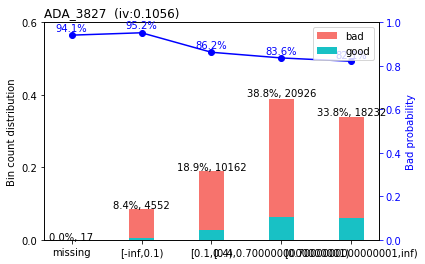

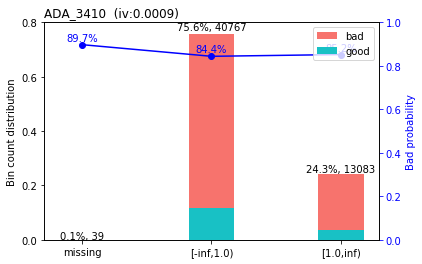

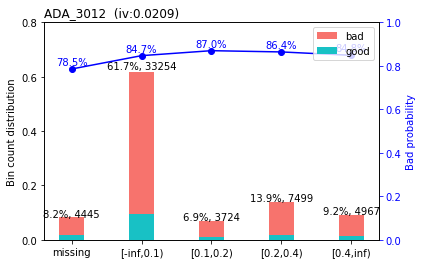

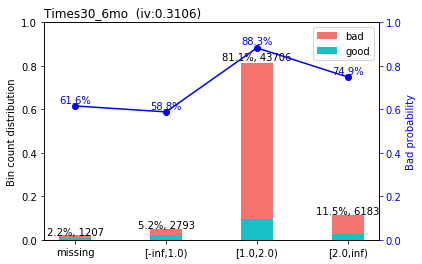

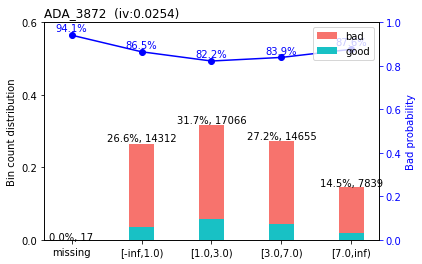

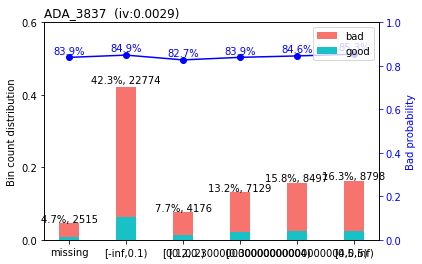

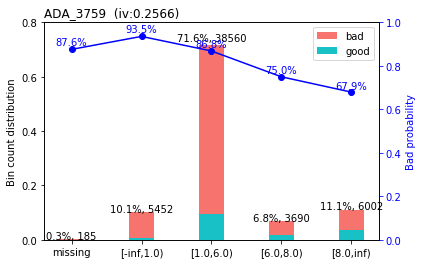

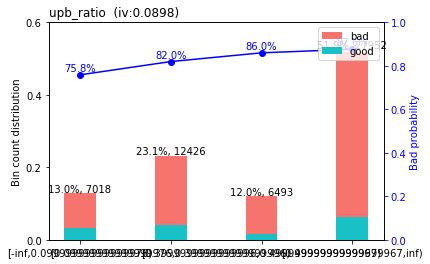

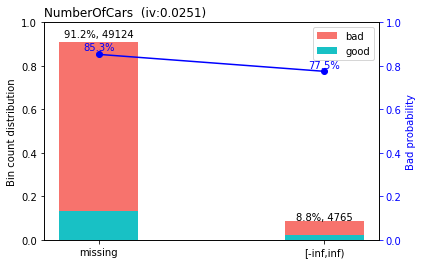

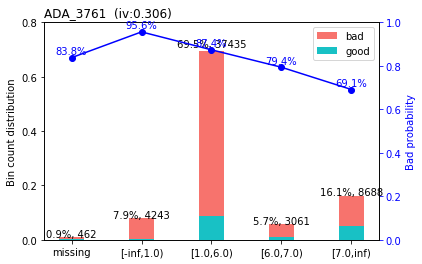

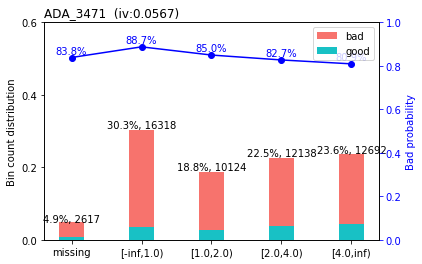

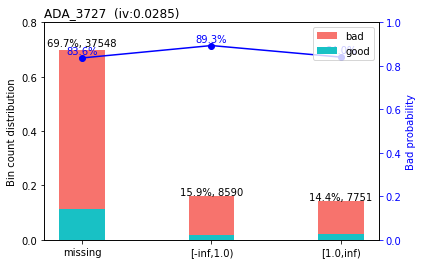

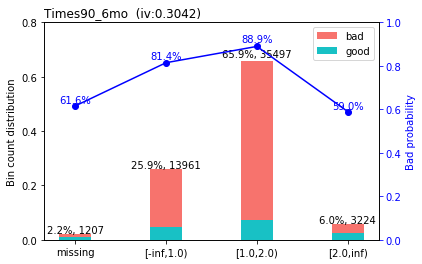

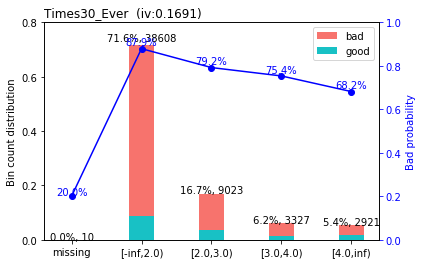

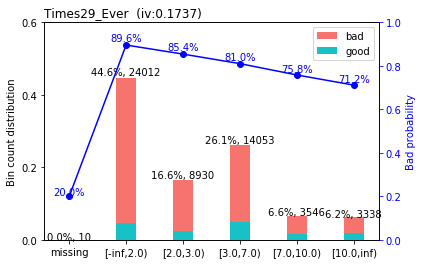

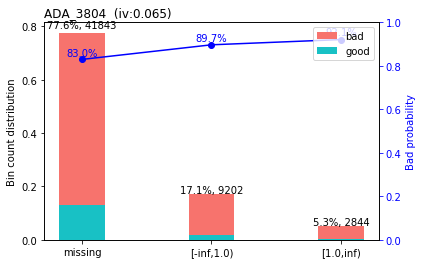

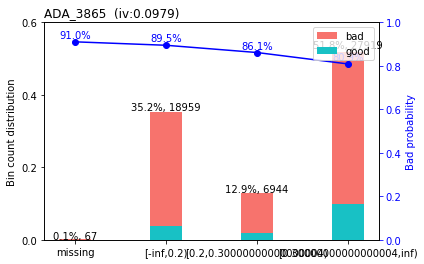

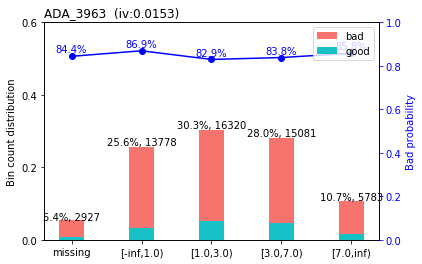

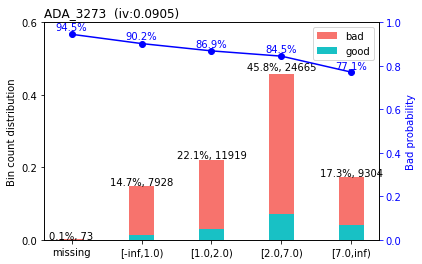

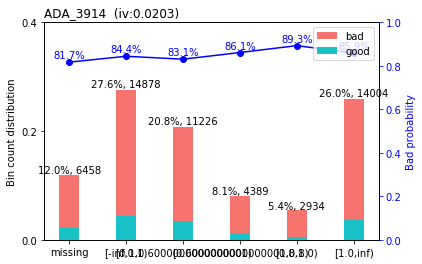

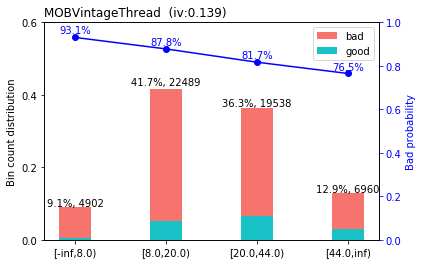

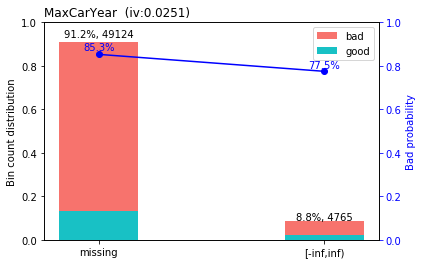

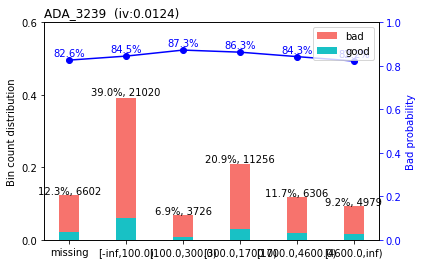

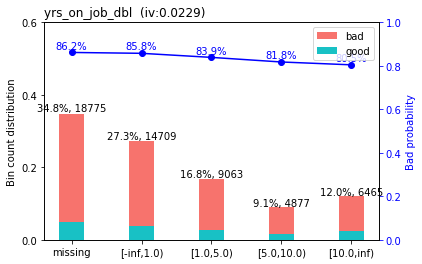

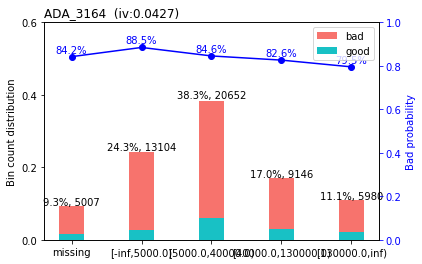

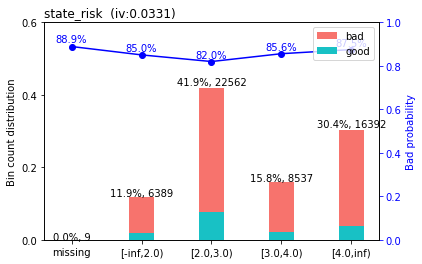

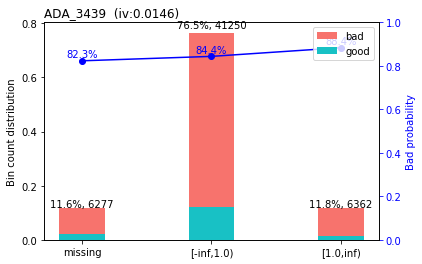

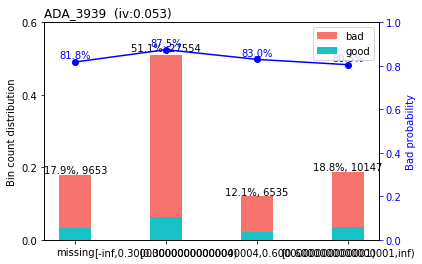

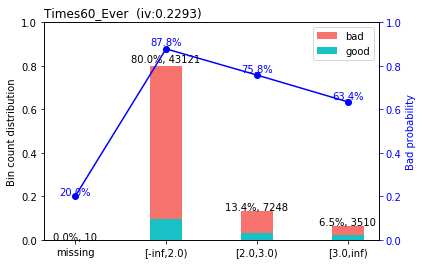

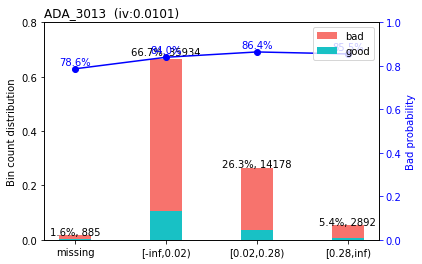

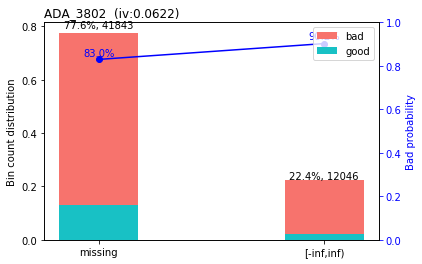

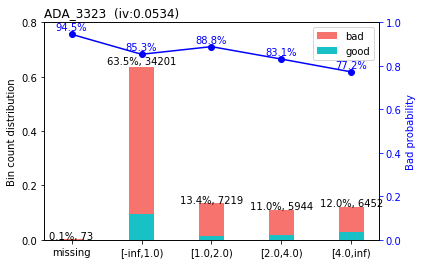

In [15]:
plotlist=sc.woebin_plot(bins)

In [16]:
for key,i in plotlist.items():
#     plt.show(i)
    i.savefig(str(key)+'.png')

In [17]:
ptable=pd.read_csv('../model_monitor/pot90_capfloor.csv')

In [25]:
def impute_pot90(df, ptable):
    for col in df.columns:
        p1 = ptable[col].min()
        p99= ptable[col].max()
    
        df.loc[df[col] <= p1, col] = p1
        df.loc[df[col] >= p99, col] = p99

   
    items=['ADA_3939']
    for item in items:
        setMax(df, ptable, item)

# #set missing to some specific value
    df['ADA_3471'].fillna(2, inplace=True)
    df['ADA_3727'].fillna(1, inplace=True)
    df['ADA_3164'].fillna(5000, inplace=True)

    
impute_pot90(df, ptable)

In [26]:
# impute all the missing value with 0
df=df.fillna(0)


In [27]:
#split the model development sample into train and test sample
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test=train_test_split(df.drop(['badflag'], axis='columns'), df.badflag, test_size=0.3)

In [28]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.feature_selection import SelectFromModel
# rf=RandomForestClassifier(n_estimators=300, min_samples_leaf=5)
XGB=XGBClassifier(n_estimators=300, min_samples_leaf=5, class_weight="balanced_subsample", randomstate=42)

In [29]:
#check VIF
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
X=add_constant(X_train)
pd.Series([variance_inflation_factor(X.values, i) for i in range(X.shape[1])], index= X.columns)

const                 48.492993
MOBVintageThread       1.511426
yrs_on_job_dbl         1.063009
number_of_payments     3.511345
NumberOfCars           5.954929
MaxCarYear             5.958837
Times29_6mo            1.533664
Times30_6mo            1.679160
Times90_6mo            1.226302
Times29_Ever           2.204759
Times30_Ever           2.822044
Times60_Ever           1.690174
ADA_3239               1.485531
ADA_3439               1.503255
ADA_3837               1.444326
ADA_3939               2.185536
ADA_3727               1.316637
ADA_3471               2.066688
ADA_3476               2.003579
ADA_3535               3.394858
ADA_3759               4.576266
ADA_3802               1.286789
ADA_3804               1.568265
ADA_3865               2.532758
ADA_3872               4.628869
ADA_3164               1.304175
ADA_3273               1.800308
ADA_3323               1.385144
ADA_3410               1.654447
ADA_3540               3.581155
ADA_3761               4.759307
ADA_3827

In [30]:
#refit the rf model
XGB.fit(X_train, y_train)
XGB.score(X_test, y_test)

0.856064823405703

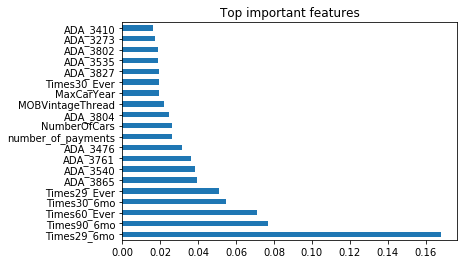

In [31]:
#rank order the variable importance
feat_importances=pd.Series(XGB.feature_importances_, index=X_train.columns)
feat_importances.nlargest(20).plot(kind='barh')
plt.title('Top important features')
plt.show()

In [32]:
df_feat=pd.DataFrame(data=feat_importances.nlargest(50))
df_feat.to_excel('feat_importance_xgb_v2_2.xlsx')

In [33]:
#output the probability of being bad;
# train_pred=rf.predict_proba(X_train2)[:,1]
test_pred=XGB.predict_proba(X_test)[:, 1]

In [34]:
#run the validation on test data
import pandas as pd

#merge only the test dataset
y_test_hat=test_pred

#convert ndarray to a dataframe, so that it can merge with true y in the merge statement

y_test_hat_df=pd.DataFrame(data=y_test_hat, columns=['Y_hats'], index=X_test.index.copy())

df_out=pd.merge(y_test, y_test_hat_df, how='left', left_index=True, right_index=True)
ks_test=ks(data=df_out, target='badflag', prob='Y_hats')

   min_score max_score   events  nonevents    total event_rate nonevent_rate  \
0   0.965031  0.994277   1591.0       26.0   1617.0     98.39%         1.61%   
1   0.948995  0.965025   1552.0       65.0   1617.0     95.98%         4.02%   
2   0.932026  0.948982   1525.0       91.0   1616.0     94.37%         5.63%   
3   0.914323  0.932012   1507.0      110.0   1617.0     93.20%         6.80%   
4   0.893279  0.914314   1462.0      154.0   1616.0     90.47%         9.53%   
5   0.866556  0.893274   1444.0      173.0   1617.0     89.30%        10.70%   
6    0.83077  0.866516   1403.0      214.0   1617.0     86.77%        13.23%   
7   0.768421  0.830738   1288.0      328.0   1616.0     79.70%        20.30%   
8   0.641167  0.768301   1139.0      478.0   1617.0     70.44%        29.56%   
9    0.13009  0.641091    805.0      812.0   1617.0     49.78%        50.22%   
10                      13716.0     2451.0  16167.0     84.84%        15.16%   

   % events % nonevents % cum_events % 

In [35]:
ks_test.to_excel('pot90_xgb_ks_v2_2.xlsx')


# !aws s3 cp pot90_xgb_ks_v2.xlsx s3://mf-ml-ds/propensity_to_pay/output/

In [36]:
#establish baseline for PSI check 
y_test_hat_df.reset_index(drop=True, inplace=True)
y_test_hat_df.to_excel('../model_monitor/pot90baseline_xgb_v2_2.xlsx', index=False)

In [37]:
#apply scorecard to oot dataset;
df_oot=pd.read_csv('s3://mf-ml-ds/propensity_to_pay/Monthly_Validation/val_202011/pot90.csv')
df_oot.head()

,FFC_Source_Input_2,RefreshFicoScore,Loan_Type,Original_Balance,Original_PI_Constant,Original_Term,lnface,LNAPRO,UPB,number_of_prior_loans,MOBVintageUnthread,MOBVintageThread,credit_score_pm,TOTAL_INCOME,DISPOSABLE_INCOME,DEBT_RATIO_DBL,yrs_on_job_dbl,BNI,AGE,day_passed_from_app_to_open3,number_of_payments,__of_days_until_pmt_date,current_DQ,NextMonth_DQ,Dataforperiod,custom_score,RBO,Cure,Def,FICO_migration,NumberOfCars,MaxCarValue,MaxCarYear,maxCarMile,SumCarValue,MinCarYear,MincarMile,Times29_6mo,Times30_6mo,Times60_6mo,Times90_6mo,Times29_9mo,Times30_9mo,Times60_9mo,Times90_9mo,Times29_12mo,Times30_12mo,Times60_12mo,Times90_12mo,Times29_Ever,Times30_Ever,Times60_Ever,Times90_Ever,ADA_3215,ADA_3236,ADA_3368,ADA_3480,ADA_3863,ADA_3894,ADA_3224,ADA_3336,ADA_3842,ADA_3101,ADA_3117,ADA_3143,ADA_3123,ADA_3138,ADA_3160,ADA_3203,ADA_3536,ADA_3547,ADA_3558,ADA_3569,ADA_3579,ADA_3593,ADA_3609,ADA_3725,ADA_3857,ADA_3102,ADA_3113,ADA_3124,ADA_3139,ADA_3150,ADA_3161,ADA_3183,ADA_3204,ADA_3217,ADA_3228,ADA_3239,ADA_3270,ADA_3290,ADA_3309,ADA_3320,ADA_3330,ADA_3340,ADA_3350,ADA_3356,ADA_3362,ADA_3369,ADA_3370,ADA_3380,ADA_3389,ADA_3398,ADA_3407,ADA_3417,ADA_3428,ADA_3439,ADA_3450,ADA_3537,ADA_3548,ADA_3559,ADA_3570,ADA_3583,ADA_3594,ADA_3605,ADA_3616,ADA_3627,ADA_3726,ADA_3748,ADA_3753,ADA_3756,ADA_3760,ADA_3825,ADA_3833,ADA_3837,ADA_3847,ADA_3854,ADA_3860,ADA_3866,ADA_3873,ADA_3874,ADA_3875,ADA_3889,ADA_3897,ADA_3898,ADA_3899,ADA_3900,ADA_3920,ADA_3921,ADA_3922,ADA_3936,ADA_3939,ADA_3944,ADA_3945,ADA_3946,ADA_3953,ADA_3954,ADA_3955,ADA_3966,ADA_3973,ADA_3974,ADA_3975,ADA_3976,ADA_3977,ADA_3984,ADA_3989,ADA_3140,ADA_3162,ADA_3184,ADA_3838,ADA_3848,ADA_3104,ADA_3126,ADA_3141,ADA_3152,ADA_3163,ADA_3185,ADA_3205,ADA_3219,ADA_3272,ADA_3292,ADA_3311,ADA_3322,ADA_3332,ADA_3351,ADA_3357,ADA_3363,ADA_3371,ADA_3382,ADA_3391,ADA_3400,ADA_3409,ADA_3419,ADA_3430,ADA_3441,ADA_3452,ADA_3539,ADA_3550,ADA_3561,ADA_3572,ADA_3585,ADA_3596,ADA_3607,ADA_3618,ADA_3629,ADA_3727,ADA_3749,ADA_3826,ADA_3830,ADA_3834,ADA_3839,ADA_3849,ADA_3855,ADA_3867,ADA_3876,ADA_3877,ADA_3878,ADA_3890,ADA_3923,ADA_3924,ADA_3925,ADA_3956,ADA_3957,ADA_3958,ADA_3985,ADA_3990,ADA_3100,ADA_3111,ADA_3122,ADA_3133,ADA_3135,ADA_3137,ADA_3148,ADA_3159,ADA_3181,ADA_3192,ADA_3237,ADA_3268,ADA_3288,ADA_3307,ADA_3318,ADA_3329,ADA_3338,ADA_3349,ADA_3355,ADA_3361,ADA_3367,ADA_3379,ADA_3388,ADA_3397,ADA_3406,ADA_3415,ADA_3426,ADA_3437,ADA_3448,ADA_3471,ADA_3472,ADA_3473,ADA_3474,ADA_3475,ADA_3476,ADA_3477,ADA_3478,ADA_3479,ADA_3535,ADA_3546,ADA_3557,ADA_3568,ADA_3581,ADA_3592,ADA_3603,ADA_3614,ADA_3625,ADA_3743,ADA_3746,ADA_3747,ADA_3752,ADA_3755,ADA_3759,ADA_3794,ADA_3795,ADA_3796,ADA_3797,ADA_3798,ADA_3799,ADA_3800,ADA_3801,ADA_3802,ADA_3803,ADA_3804,ADA_3805,ADA_3806,ADA_3807,ADA_3812,ADA_3813,ADA_3814,ADA_3815,ADA_3832,ADA_3843,ADA_3844,ADA_3846,ADA_3864,ADA_3865,ADA_3870,ADA_3871,ADA_3872,ADA_3888,ADA_3895,ADA_3896,ADA_3902,ADA_3903,ADA_3904,ADA_3905,ADA_3907,ADA_3908,ADA_3909,ADA_3911,ADA_3912,ADA_3913,ADA_3917,ADA_3918,ADA_3919,ADA_3935,ADA_3938,ADA_3941,ADA_3942,ADA_3943,ADA_3950,ADA_3951,ADA_3952,ADA_3965,ADA_3968,ADA_3969,ADA_3970,ADA_3971,ADA_3972,ADA_3983,ADA_3988,ADA_3105,ADA_3116,ADA_3127,ADA_3136,ADA_3142,ADA_3153,ADA_3164,ADA_3193,ADA_3206,ADA_3231,ADA_3242,ADA_3273,ADA_3293,ADA_3312,ADA_3323,ADA_3333,ADA_3352,ADA_3358,ADA_3364,ADA_3372,ADA_3383,ADA_3392,ADA_3401,ADA_3410,ADA_3420,ADA_3431,ADA_3442,ADA_3453,ADA_3540,ADA_3551,ADA_3562,ADA_3573,ADA_3586,ADA_3597,ADA_3608,ADA_3619,ADA_3630,ADA_3728,ADA_3750,ADA_3757,ADA_3761,ADA_3827,ADA_3835,ADA_3840,ADA_3858,ADA_3868,ADA_3879,ADA_3880,ADA_3881,ADA_3891,ADA_3926,ADA_3927,ADA_3928,ADA_3959,ADA_3960,ADA_3961,ADA_3986,ADA_3991,ADA_3000,ADA_3001,ADA_3002,ADA_3008,ADA_3009,ADA_3010,ADA_3011,ADA_3012,ADA_3013,ADA_3014,ADA_3015,ADA_3016,ADA_3017,ADA_3018,ADA_3019,ADA_3020,ADA_3021,ADA_3022,ADA_3023,ADA_3024,ADA_3025,ADA_3026,ADA_3027,ADA_3028,ADA_3029,ADA_3030,ADA_3031,ADA_3993,ADA_3994,ADA_3995,ADA_3165,ADA_3177,ADA_3195,ADA_3207,ADA_

In [38]:
y_oot=df_oot.loc[: ,'badflag']
X_oot=df_oot.loc[: , df_oot.columns!='badflag']
X_oot=X_oot[pot90_columns]

In [39]:
impute_pot90(X_oot, ptable)

In [40]:
X_oot=X_oot.fillna(0)


In [41]:

oot_pred=XGB.predict_proba(X_oot)[:, 1]


In [42]:
#merge only the validation dataset
y_oot_hat=oot_pred

#convert ndarray to a dataframe, so that it can merge with true y in the merge statement

y_oot_hat_df=pd.DataFrame(data=y_oot_hat, columns=['Y_hats'], index=X_oot.index.copy())

df_out=pd.merge(y_oot, y_oot_hat_df, how='left', left_index=True, right_index=True)
ks_oot=ks(data=df_out, target='badflag', prob='Y_hats')

   min_score max_score  events  nonevents  total event_rate nonevent_rate  \
0   0.961665  0.991911    1693         39   1732     97.75%         2.25%   
1   0.944086   0.96166    1668         63   1731     96.36%         3.64%   
2   0.927122  0.944084    1651         82   1733     95.27%         4.73%   
3   0.909554  0.927106    1635         96   1731     94.45%         5.55%   
4   0.889833  0.909541    1593        139   1732     91.97%         8.03%   
5   0.864643  0.889832    1549        183   1732     89.43%        10.57%   
6     0.8309  0.864642    1493        238   1731     86.25%        13.75%   
7   0.769969  0.830878    1413        319   1732     81.58%        18.42%   
8   0.647368  0.769968    1257        475   1732     72.58%        27.42%   
9   0.126195   0.64721     895        837   1732     51.67%        48.33%   
10                       14847       2471  17318     85.73%        14.27%   

   % events % nonevents % cum_events % cum_nonevents    KS  
0    11.40%   

In [43]:
#export the KS table to an excel file
ks_oot.to_excel('pot90_oot_xgb_ks_v2.xlsx')

!aws s3 cp pot90_ks_v2.xlsx s3://mf-ml-ds/propensity_to_pay/Monthly_Validation/val_202011/

upload: ./pot90_ks_v2.xlsx to s3://mf-ml-ds/propensity_to_pay/Monthly_Validation/val_202011/pot90_ks_v2.xlsx


In [44]:
upload_model(XGB, 'pot90_xgb_model_v2_2')

In [45]:
#calculate PSI for score;
import math
psitable=psi(test_pred, oot_pred, group=10)

   lowercut  uppercut  ben_cnt   ben_pct  comp_cnt  comp_pct  pct_diff  \
0  0.130090  0.641091   1617.0  0.100019    1672.0  0.096547  0.003472   
1  0.641167  0.768301   1617.0  0.100019    1755.0  0.101340 -0.001321   
2  0.768421  0.830770   1617.0  0.100019    1757.0  0.101455 -0.001437   
3  0.830770  0.866556   1617.0  0.100019    1865.0  0.107691 -0.007673   
4  0.866597  0.893279   1617.0  0.100019    1875.0  0.108269 -0.008250   
5  0.893298  0.914344   1617.0  0.100019    1915.0  0.110579 -0.010560   
6  0.914345  0.932059   1617.0  0.100019    1777.0  0.102610 -0.002591   
7  0.931967  0.948945   1616.0  0.099957    1742.0  0.100589 -0.000632   
8  0.948959  0.964955   1616.0  0.099957    1585.0  0.091523  0.008433   
9  0.964959  0.994277   1616.0  0.099957    1373.0  0.079282  0.020675   

   info_odds       psi  
0   0.035326  0.000123  
1  -0.013122  0.000017  
2  -0.014261  0.000020  
3  -0.073914  0.000567  
4  -0.079262  0.000654  
5  -0.100371  0.001060  
6  -0.0255

In [46]:
#export the KS table to an excel file
ks_oot.to_excel('pot90_xgb_psi_v2_2.xlsx')
